# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

## Define Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


## Define Folder Output

In [3]:
os.makedirs("./output", exist_ok=True)

## Data Visualization

In [4]:
df = pd.read_csv('./dataset/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [5]:
df.shape

(27643, 3)

In [6]:
unique, counts = np.unique(df['Popularity'].values, return_counts=True)
dict(zip(unique, counts))

{-1: 14011, 1: 13632}

In [7]:
def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace ('-', '') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    return text

print('Before:', df.iloc[0]['Page content'])
processed_txt = preprocessor(df.iloc[0]['Page content'])
print('After:', processed_txt)

Before: <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks and figure o

Check what the data looks like

In [8]:
with open("./output/out.txt",'w') as f:
    print(BeautifulSoup(df.iloc[0]['Page content'], 'html.parser').prettify(), file=f)

In [9]:
with open("./output/out2.txt",'w') as f:
    print(BeautifulSoup(df.iloc[1]['Page content'], 'html.parser').prettify(), file=f)

In [10]:
with open("./output/out3.txt",'w') as f:
    print(BeautifulSoup(df.iloc[300]['Page content'], 'html.parser').prettify(), file=f)

# Preprocess Data

## Split X and y data

In [11]:
X = df['Page content'].values[:, np.newaxis]
y = df['Popularity'].values[:, np.newaxis]
X.shape, y.shape

((27643, 1), (27643, 1))

## Scale y data from [-1, 1] to [0, 1]
Useful for logistic regression model since y has to be [0, 1]

In [12]:
min, max = 0, 1
y_std = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))
y = y_scaled = y_std * (max - min) + min
y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

## Feature Extraction from X 

### Check the tags in all the data

#### Get Title from Data

In [13]:
def get_title_html(X):
    titles = []

    for x_data in X:
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        title = soup.find_all(attrs={"class": "title"})
        # print(title[0].get_text)
        if title is not None:
            titles.append(title[0].get_text())
        else:
            titles.append(np.nan)
    
    titles = np.array(titles)[:, np.newaxis]
    return titles

#### Get Category from Data

In [14]:
def get_categories_html(X):
    categories_extracted = []
    for x_data in X:
        categories = []
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        html_cats = soup.find_all(attrs={"href": re.compile(r'/category/')})

        for cat in html_cats:
            # print(cat.get('href'))
            categories.append(cat.get_text())

        category_str = ""
        if len(categories) != 0:
            category_str = " ".join(categories) 
        else:
            category_str = np.nan

        categories_extracted.append(category_str)
        
    categories_extracted = np.array(categories_extracted)[:, np.newaxis]
    return categories_extracted

#### Get Time from Data

In [15]:
def get_days_and_dates_html(X):
    dates = []
    days = []
    for x_data in X:
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        # find only the date when it is written
        html_date = soup.find("time")

        if html_date is not None:
            # print(cat.get('href'))
            # ex of pattern : Wed, 19 Jun 2013 15:04:30 +0000
            days.append(html_date.get('datetime').replace(',', ' ')[0:3])
            dates.append(html_date.get_text())
        else:
            days.append(np.nan)
            dates.append(np.nan)

    return days, dates

In [16]:
# Parse date and time
from datetime import datetime
from dateutil import parser
import pytz

def date_week_parser(day):
    dict_days = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6}
    return dict_days[day]

def date_parser(time):
    timestamp = parser.parse(time)
    # Also convert everything to UTC
    timestamp = timestamp.astimezone(pytz.UTC)
    return timestamp

def get_year(dt):
    # Extract individual components
    return dt.year

def get_month(dt):
    return dt.month

def get_date_day(dt):
    return dt.day

def get_time_second(dt):
    hour = dt.hour
    minute = dt.minute
    second = dt.second
    return hour * 3600 + minute * 60 + second
        
# print('before', dates[456])
# dt = date_parser(dates[456])
# print(dt)

##### Execute time and date features

In [17]:
def extract_date_and_time_features(X):
    days, dates = get_days_and_dates_html(X)
    features_day = []
    for day in days:
        feature_day = date_week_parser(day) 
        features_day.append(feature_day)

    features_yr = []
    features_time = []
    features_month = []
    features_date = []

    for date in dates:
        dt = date_parser(date)
        yr = get_year(dt)
        time = get_time_second(dt)
        month = get_month(dt)
        date_day = get_date_day(dt)

        features_yr.append(yr)
        features_time.append(time)
        features_month.append(month)
        features_date.append(date_day)

    features_day = np.array(features_day)[:, np.newaxis]
    features_yr = np.array(features_yr)[:, np.newaxis]
    features_time = np.array(features_time)[:, np.newaxis]
    features_month = np.array(features_month)[:, np.newaxis]
    features_date = np.array(features_date)[:, np.newaxis]

    return features_day, features_yr, features_time, features_month, features_date

#### Get Video Count

In [ ]:
def get_video_count_html(X):
    lst_num_videos = []
    for x_data in X:
        categories = []
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        html_vid = soup.find_all('iframe')

        num_of_videos = len(html_vid)
        lst_num_videos.append(num_of_videos)
        
    lst_num_videos = np.array(lst_num_videos)[:, np.newaxis]
    return lst_num_videos

#### Get Image Count

In [ ]:
def get_img_count_html(X):
    lst_num_imgs = []
    for x_data in X:
        categories = []
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        html_img = soup.find_all('img')

        num_of_photos = len(html_img)
        lst_num_imgs.append(num_of_photos)
        
    lst_num_imgs = np.array(lst_num_imgs)[:, np.newaxis]
    return lst_num_imgs

#### Get Word Count

In [ ]:
def get_word_count_html(X):
    lst_word_count = []
    for x_data in X:
        categories = []
        soup = BeautifulSoup(x_data[0], 'html.parser')
        # print(soup.title)
        content_element = soup.find('section', class_='article-content')
        content = content_element.text

        word_count = len(content.split())
        lst_word_count.append(word_count)
        
    lst_word_count = np.array(lst_word_count)[:, np.newaxis]
    return lst_word_count


### Preprocess
Call the function and combine data together into an np.array

In [18]:
def preprocess_obtain_features(X):
    titles = get_title_html(X)
    categories_extracted = get_categories_html(X)
    features_day, features_yr, features_time, features_month, features_date = extract_date_and_time_features(X)
    concatenated_features = np.concatenate((titles, categories_extracted, features_day, features_yr, features_time, features_month, features_date), axis=1)
    return concatenated_features    

## Tokenizer

In [19]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/audreych/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Combine Feature Extracted into a new dataframe

In [20]:
old_features_name = [c for c in df.columns]
new_features_name = ['Id', 'Popularity', 'Title', 'Category', 'Day', 'Year', 'Time', 'Month', 'Date']
# new_features_name = [c for c in df.columns]
print(old_features_name)

['Id', 'Popularity', 'Page content']


### Add new column feature in the dataframe
Given column name and also the data to be added

In [21]:
def add_new_features_df(df, new_feature_name, new_data):
    if (len(new_data.shape) == 2 and new_data.shape[1] != 1) or (len(new_data.shape) > 2):
        print('Check dimension again, it should be 2 dimension and (sample, 1) or (sample, )')
        return
    elif len(new_data.shape) == 2 and new_data.shape[1] == 1:
        new_data = new_data.reshape(-1)
    
    new_data = np.array(new_data)
    if new_feature_name not in df.columns:
        df[new_feature_name] = new_data.tolist()

dummy = np.zeros((df.shape[0], 1))
new_df = df.copy()
add_new_features_df(new_df, 'dummy', dummy)
print(new_df.head())

   Id  Popularity                                       Page content  dummy
0   0          -1  <html><head><div class="article-info"> <span c...    0.0
1   1           1  <html><head><div class="article-info"><span cl...    0.0
2   2           1  <html><head><div class="article-info"><span cl...    0.0
3   3          -1  <html><head><div class="article-info"><span cl...    0.0
4   4          -1  <html><head><div class="article-info"><span cl...    0.0


### Utility Function for Deleting Column in DataFrame
delete columns given columns name

In [22]:
def delete_features_df(df, feature_name):
    if feature_name in df.columns:
        df.drop(columns=feature_name, inplace=True)
    
delete_features_df(new_df, 'dummy')
print(new_df.head())

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Execute and Get New Dataframe

In [23]:
def get_new_df(X, df, new_features_name, old_features_name):
    concatenated_features = preprocess_obtain_features(X)

    new_df = df.copy()
    new_feat_not_in_old_df = [item for item in new_features_name if item not in old_features_name]

    for (feature_name, extracted_data) in zip(new_feat_not_in_old_df, np.transpose(concatenated_features)):
        add_new_features_df(new_df, feature_name, extracted_data)

    # print(new_df.head())
    old_feat_not_in_new_df = [item for item in old_features_name if item not in new_features_name]

    for feature_name in old_feat_not_in_new_df:
        delete_features_df(new_df, feature_name)

    return new_df   

In [24]:
new_df = get_new_df(X, df, new_features_name, old_features_name)
print(new_df.head())

   Id  Popularity                                              Title  \
0   0          -1  NASA's Grand Challenge: Stop Asteroids From De...   
1   1           1  Google's New Open Source Patent Pledge: We Won...   
2   2           1  Ballin': 2014 NFL Draft Picks Get to Choose Th...   
3   3          -1        Cameraperson Fails Deliver Slapstick Laughs   
4   4          -1  NFL Star Helps Young Fan Prove Friendship With...   

                                            Category Day  Year   Time Month  \
0  Asteroid Asteroids challenge Earth Space U.S. ...   3  2013  54270     6   
1  patent-lawsuit theater Apps and Software Googl...   4  2013  63655     3   
2  NFL ESPN Entertainment NFL NFL Draft Sports Te...   3  2014  69320     5   
3            YouTube Sports Video Videos Watercooler   5  2013   8810    10   
4  NFL Instagram Entertainment instagram instagra...   4  2014  12703     4   

  Date  
0   19  
1   28  
2    7  
3   11  
4   17  


## Save new features to csv

In [ ]:
new_df.to_csv('./output/modif_dataset.csv', index=False)

In [35]:
X = new_df.iloc[:, 2:]
y = new_df.iloc[:, 1:2]
X.shape, y.shape

((27643, 7), (27643, 1))

## Tf-idf and PCA

TODO : don't leak the training data to fit the category

### Tfidf definition

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_fun(X_train_df, feature_name):
    tfidf = TfidfVectorizer(ngram_range=(1,1),
                            tokenizer=tokenizer_stem_nostop)

    tfidf.fit(X_train_df[feature_name])

    top = 10
    # get idf score of vocabularies
    idf = tfidf.idf_
    print('[vocabularies with smallest idf scores]')
    sorted_idx = idf.argsort()

    for i in range(top):
        print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

    doc_tfidf = tfidf.transform(X_train_df[feature_name]).toarray()
    tfidf_sum = np.sum(doc_tfidf, axis=0)
    print("\n[vocabularies with highest tf-idf scores]")
    for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                            np.sort(tfidf_sum)[::-1][:top]):
        print('{}: {}'.format(tok, v))
    
    return tfidf

### Vectorize Features

In [37]:
def tfidf_vectorize_features(X, feature_name, tfidf=None, training=False):
    if training == True:
        tfidf = tfidf_fun(X, feature_name)
    else:
        if tfidf == None:
            print("Pass an existing tfidf for validation")
            return
    
    tfidf_doc = tfidf.transform(X[feature_name]).toarray()
    # tfidf_doc_val = tfidf.transform(X_val['Category']).toarray()
    return tfidf, tfidf_doc

### Use PCA to reduce dimension 
This is to make dimension smaller, since we still need to tf-idf title

In [38]:
from sklearn.preprocessing import StandardScaler # scikit-learn 1.3.1
from sklearn.decomposition import PCA

def std_scale(X, sc=None, training=False):
    if training == True:
        sc = StandardScaler()
        sc.fit(X)
    else:
        if sc == None:
            print("Pass an existing scaler for validation")
            return

    Z = sc.transform(X)
    return sc, Z

In [39]:
def PCA_fun(X, n_components=3000, pca=None, training=False):
    if training == True:
        pca = PCA(n_components=n_components)
        pca.fit(X)
    else:
        if pca == None:
            print("Pass an existing tfidf for validation")
            return

    Z_pca = pca.transform(X)
    return pca, Z_pca

### Save the Compressed Category

In [40]:
import _pickle as pkl
def save_trainable(sc, tfidf, pca, name='cat'):
    # dump to disk
    pkl.dump(sc, open(f'./output/sc_{name}.pkl', 'wb'))
    pkl.dump(tfidf, open(f'./output/tfidf_{name}.pkl', 'wb'))
    pkl.dump(pca, open(f'./output/pca_{name}.pkl', 'wb'))
    # pkl.dump(Z_pca, open('./output/doc_tfidf_pca.pkl', 'wb'))

### Wrap it as one func

In [41]:
def feature_vectorize_procedure(X, feature_name, n_components_pca=3000, tfidf=None, sc=None, pca=None, training=False, file_name='cat'):
    tfidf, tfidf_doc = tfidf_vectorize_features(X, feature_name, tfidf=tfidf, training=training)
    sc, Z = std_scale(tfidf_doc, sc=sc, training=training)
    pca, Z_pca = PCA_fun(Z, n_components=n_components_pca, pca=pca, training=training)
    if training==True:
        save_trainable(sc, tfidf, pca, name=file_name)
    return Z_pca, tfidf, sc, pca

## Re-combine Features

In [42]:
def combine_features(X, Z_pca_ttl, Z_pca_cat):
    delete_features_df(X, 'Title')
    delete_features_df(X, 'Category')
    X = np.concatenate((X, Z_pca_ttl, Z_pca_cat), axis=1)
    return X

## Evaluate Model

In [43]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=3)

# depending on the kfold
roc_auc_train = []
roc_auc_test = []

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index, :]
    X_val = X.iloc[val_index, :]
    y_val = y.iloc[val_index, :]
    print(X_train.shape, X_val.shape)
    # Do this for both title and category
    Z_pca_cat, tfidf, sc, pca = feature_vectorize_procedure(X_train, 'Category', n_components_pca=3000, tfidf=None, sc=None, pca=None, training=True, file_name='cat')
    Z_pca_cat_val, _, _, _ = feature_vectorize_procedure(X_val, 'Category', n_components_pca=3000, tfidf=tfidf, sc=sc, pca=pca, training=False, file_name='cat')

    Z_pca_ttl, tfidf, sc, pca = feature_vectorize_procedure(X_train, 'Title', n_components_pca=5000, tfidf=None, sc=None, pca=None, training=True, file_name='title')
    Z_pca_ttl_val, _, _, _ = feature_vectorize_procedure(X_val, 'Title', n_components_pca=3000, tfidf=tfidf, sc=sc, pca=pca, training=False, file_name='title')

    X_train = combine_features(X_train, Z_pca_ttl, Z_pca_cat)
    X_val = combine_features(X_val, Z_pca_ttl_val, Z_pca_cat_val)

    
    clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)

    pkl.dump(clf, open(f'./output/model-k{i}.pkl', 'wb'))

    roc_auc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    roc_auc_test.append(roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))

print('avg roc_auc_train =', np.average(roc_auc_train))
print('avg roc_auc_test =', np.average(roc_auc_test))

(18428, 7) (9215, 7)


[vocabularies with smallest idf scores]
world: 2.37
tech: 2.60
entertain: 2.69
watercool: 2.70
busi: 2.79
u.s.: 2.86
video: 2.95
app: 3.02
softwar: 3.08
mobil: 3.10

[vocabularies with highest tf-idf scores]
video: 985.4462807853151
world: 788.013689491839
busi: 633.662226007963
watercool: 549.9942307441912
entertain: 547.3241856611837
tech: 544.4960612322128
app: 532.1345287463241
u.s.: 517.1376614649233
twitter: 420.4982802191957
media: 409.2324875723526
[vocabularies with smallest idf scores]
new: 3.94
app: 4.48
googl: 4.49
video: 4.52
twitter: 4.68
facebook: 4.69
get: 4.70
make: 4.80
appl: 4.81
first: 4.84

[vocabularies with highest tf-idf scores]
new: 212.39890196162423
app: 160.8213563402999
googl: 153.4905448181874
video: 140.55324470216217
facebook: 133.91177288109571
twitter: 131.24350907912617
get: 121.81682108547119
appl: 114.35372533748621
make: 111.84357356467666
know: 108.32842201464089


## Train All Data

In [ ]:
Z_pca_cat, tfidf, sc, pca = feature_vectorize_procedure(X_train, 'Category', n_components_pca=3000, tfidf=None, sc=None, pca=None, training=True, file_name='cat')
Z_pca_ttl, tfidf, sc, pca = feature_vectorize_procedure(X_train, 'Title', n_components_pca=5000, tfidf=None, sc=None, pca=None, training=True, file_name='title')
X_train = combine_features(X, Z_pca_ttl, Z_pca_cat)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
pkl.dump(clf, open(f'./output/model.pkl', 'wb'))

## Model (used to check which param is good)

[0.5374442443406697, 0.5433238487634284, 0.5433644221305467, 0.5432824901053337, 0.5461816535086801, 0.5459289206960819, 0.5433769867861705, 0.5523324450819844, 0.5549526993068499]


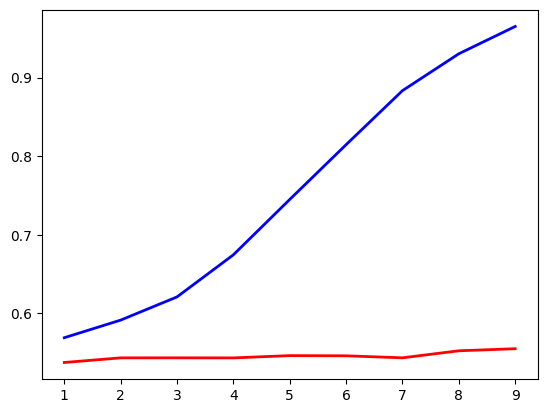

In [ ]:
# import _pickle as pkl

# roc_auc_train = []
# roc_auc_test = []

# max_depth = 10
# for d in range(1, max_depth):
#     clf = RandomForestClassifier(max_depth=d, random_state=0)
#     clf.fit(X_train, y_train)
#     # dump to disk
#     pkl.dump(clf, open(f'./output/model_forest_{d}.pkl', 'wb'))
    
#     roc_auc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
#     roc_auc_test.append(roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
    
# plt.plot(range(1, max_depth), roc_auc_train, label = 'Training error', color = 'blue', linewidth = 2)
# plt.plot(range(1, max_depth), roc_auc_test, label = 'Testing error', color = 'red', linewidth = 2)


## Evaluate Model

## Predict

### Load testing dataset

In [ ]:
df = pd.read_csv('./dataset/test.csv')
print(df.head(5))

In [ ]:
X_test = df['Page content'].values[:, np.newaxis]

### Load All Python trainable obj

In [ ]:
# category
sc_cat = pkl.load(open('./output/sc_cat.pkl', 'rb'))
tfidf_cat = pkl.load(open('./output/tfidf_cat.pkl', 'rb'))
pca_cat = pkl.load(open('./output/pca_cat.pkl', 'rb'))

# title
sc_title = pkl.load(open('./output/sc_title.pkl', 'rb'))
tfidf_title = pkl.load(open('./output/tfidf_title.pkl', 'rb'))
pca_title = pkl.load(open('./output/pca_title.pkl', 'rb'))

# model
clf = pkl.load(open('./output/model.pkl', 'rb'))

In [ ]:
old_features_name = [c for c in df.columns]
new_features_name = ['Id', 'Title', 'Category', 'Day', 'Year', 'Time', 'Month', 'Date']
# new_features_name = [c for c in df.columns]
print(old_features_name)
new_df = get_new_df(X, df, new_features_name, old_features_name)
print(new_df.head())
# without id
X_test = new_df.iloc[:, 1:]

In [ ]:
Z_pca_cat, tfidf, sc, pca = feature_vectorize_procedure(X_test, 'Category', n_components_pca=3000, tfidf=None, sc=None, pca=None, training=True, file_name='cat')
Z_pca_ttl, tfidf, sc, pca = feature_vectorize_procedure(X_test, 'Title', n_components_pca=5000, tfidf=None, sc=None, pca=None, training=True, file_name='title')
X_test = combine_features(X_test, Z_pca_ttl, Z_pca_cat)

In [ ]:
y_pred = clf.predict_proba(X_test)[:, 1]

### Write to csv

In [ ]:
# write to csv
df = pd.DataFrame({'Id': df['Id'], 'Popularity': y_pred})
df.to_csv('./output/submission.csv', index=False)